# 3. Capstone Pre-processing Training & Data Development

In [1]:
# Libraries imported for this notebook.

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
# Read Lake_Fictitious_AquaRealTime_Data_EDA into a dataframe, formatted dates, and indexed dates.

df = pd.read_excel('Lake_Fictitious_AquaRealTime_Data_EDA.xlsx', parse_dates=True, index_col=[0])

In [3]:
# Looked at shape

df.shape

(53850, 5)

## Grouping Rows

I will now calculate the mean values of metrics over a one day period so I can use these data for my model. I'm dong this because I want to be able to forcast multiple days in advance and the data is currently by the half hour. Typically, time series data granularity, or unit, should be the same as the prediction unit, in this case, days. I'm doing this step now becasue this summerizing process can sometime make non-stationary data into stationary data.

In [4]:
# Grouped rows by day.

# Create a copy of the original DataFrame
mean_df = df.copy()

# Extract date from timestamps and set as index
mean_df.index = pd.to_datetime(mean_df.index).date

# Group by date and calculate mean
mean_df = mean_df.groupby(mean_df.index).mean()

# Print the summary DataFrame
mean_df

,light,waterTemp,turbidity,phycocyanin,chlorA
2021-01-27,178.484613,12.553846,22.200385,29.030577,406.140191
2021-01-28,133.795139,11.198958,23.549844,32.204582,510.559024
2021-01-29,118.664582,11.183108,23.722331,32.419998,484.313971
2021-01-30,140.362499,11.247973,23.770979,32.419998,456.055591
2021-01-31,134.059028,11.950169,22.993095,29.996562,422.760014
...,...,...,...,...,...
2024-02-19,148.206250,15.650000,2.264792,8.405208,85.007083
2024-02-20,101.362501,15.100000,2.563333,9.267292,89.794999
2024-02-21,172.979168,15.237500,2.962500,9.417917,92.104791
2024-02-22,246.960419,15.189583,3.552292,11.089583,103.188958


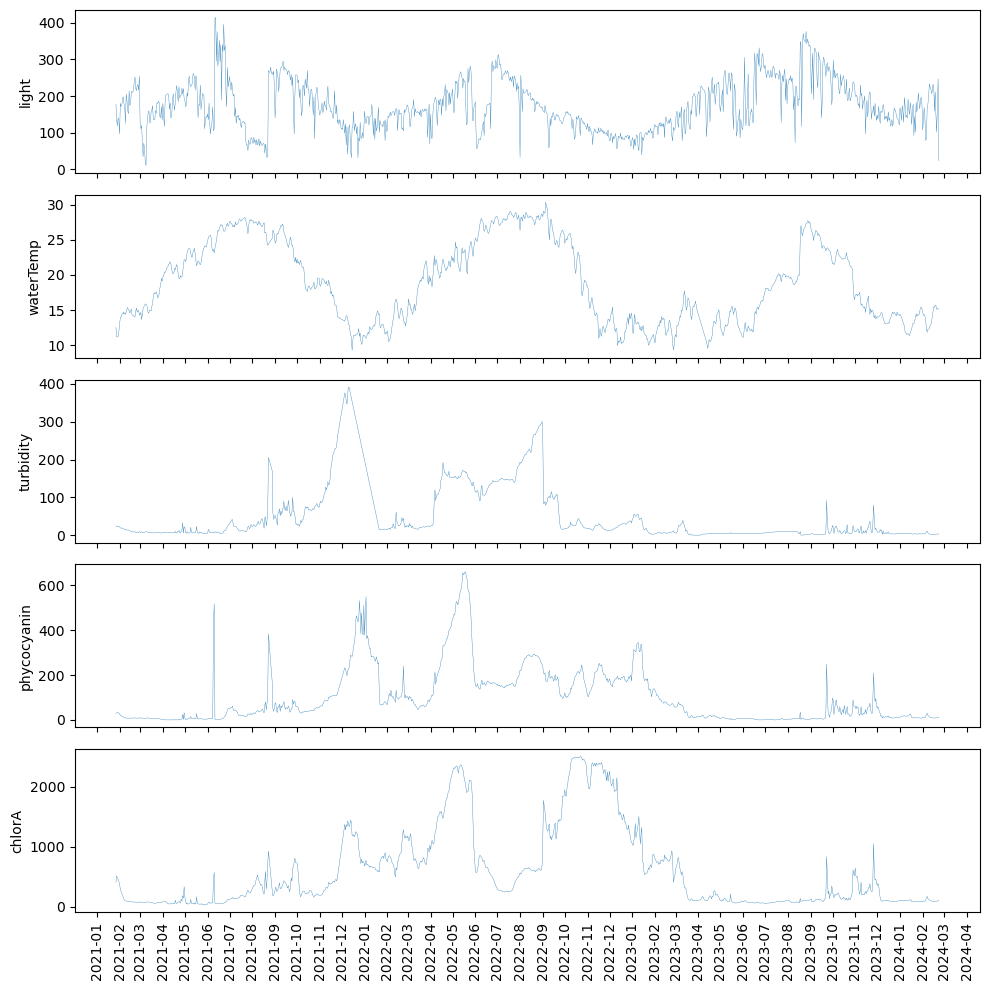

In [5]:
# Plotted summerized row data.

fig, axes = plt.subplots(nrows=len(mean_df.columns), ncols=1, figsize=(10, 2 * len(mean_df.columns)), sharex=True)
for i, column in enumerate(mean_df.columns):
    axes[i].plot(mean_df.index, mean_df[column], linewidth=0.25)
    axes[i].set_ylabel(column)
    axes[i].xaxis.set_major_locator(MonthLocator())
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Checked if summerizing made the data stationary.

In [6]:
# Redefined function to run KPSS test.

def kpss_test(timeseries, column_name):
    print('Results of KPSS Test for column "{}":'.format(column_name))
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)
    print()

In [7]:
# Ran KPSS for first-order differenced metrics.

for column in mean_df.columns:
    kpss_test(mean_df[column], column)

Results of KPSS Test for column "light":
Test Statistic            0.29502
p-value                   0.10000
#Lags Used               19.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

Results of KPSS Test for column "waterTemp":
Test Statistic            0.639977
p-value                   0.019002
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "turbidity":
Test Statistic            0.910671
p-value                   0.010000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "phycocyanin":
Test Statistic            0.835059
p-value    

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.p

The p-value for 'light' is >0.10 which is more than the significance level of 0.05. Therefore, I fail to reject the null hypothesis of stationarity for this metric. It is likely stationary according to the KPSS test. 'waterTemp', 'turbidity', 'phycocyanin', 'chlorA', however, all have p-value <0.01, which idicates that they are non-stationary.

In [8]:
# Redefined function to run ADF test.

def adf_test(timeseries, column_name):
    print('Results of ADF Test for column "{}":'.format(column_name))
    adftest = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)
    print()

In [9]:
# Ran ADF for first-order differenced metrics.

for column in mean_df.columns:
    adf_test(mean_df[column], column)

Results of ADF Test for column "light":
Test Statistic                   -4.816401
p-value                           0.000051
#Lags Used                        4.000000
Number of Observations Used    1118.000000
Critical Value (1%)              -3.436213
Critical Value (5%)              -2.864129
Critical Value (10%)             -2.568148
dtype: float64

Results of ADF Test for column "waterTemp":
Test Statistic                   -2.262546
p-value                           0.184332
#Lags Used                        2.000000
Number of Observations Used    1120.000000
Critical Value (1%)              -3.436202
Critical Value (5%)              -2.864124
Critical Value (10%)             -2.568146
dtype: float64

Results of ADF Test for column "turbidity":
Test Statistic                   -2.764986
p-value                           0.063452
#Lags Used                        9.000000
Number of Observations Used    1113.000000
Critical Value (1%)              -3.436239
Critical Value (5%)    

The p-values for 'light' and 'phycocyanin' are less <0.05, indicating strong evidence against the presence of a unit root. Thus, I reject the null hypothesis for these variables, suggesting that they are likely stationary according to the ADF test. 'waterTemp', 'turbidity', 'chlorA', however, all have p-value >0.05, which idicates that they are non-stationary.

Together, the KPSS and ADF tests indicate that 'light' is stationary and 'waterTemp', 'turbidity', and 'chlorA' metrics are non-stationary. As for 'phycocyanin', the KPSS test indicates that the metric is non-stationary while the ADF test indicates that it is stationary. This apparent contradiction indicates that 'phycocyanin' is difference stationary. As a result, all metrics but 'light' will need to be detrended.

## Feature Engineering

### Temporal

#### Differencing

'waterTemp', 'turbidity', 'phycocyanin', and 'chlorA' need to be detrended so I performed differencing to compute the differences between consecutive data points. This technique is often performed for time series models and can transform a non-stationary time series into a stationary one and remove trends and seasonality. Overall, differencing can be beneficial because it stabilizes the mean and variance of the data, making it easier to identify underlying patterns and relationships.

In [10]:
# Added first-order differenced features to mean_df for all metric but light.

# Got the columns to perform differencing on (excluding 'light')
columns_to_difference = mean_df.columns.drop('light')

# Performed first-order differencing on specified columns
first_differences = mean_df[columns_to_difference].diff().add_prefix('d_')

# Concatenated the results with the original DataFrame
mean_df = pd.concat([mean_df, first_differences], axis=1).dropna()

In [11]:
# Looked at just 'phycocyanin' to check differencing calculations.

selected_columns = ['phycocyanin', 'd_phycocyanin']
new_df = mean_df.loc[:, selected_columns]
new_df.head(10)

,phycocyanin,d_phycocyanin
2021-01-28,32.204582,3.174005
2021-01-29,32.419998,0.215416
2021-01-30,32.419998,0.000000
2021-01-31,29.996562,-2.423436
2021-02-01,28.018646,-1.977916
2021-02-02,20.748334,-7.270312
2021-02-03,18.696979,-2.051354
2021-02-04,16.626042,-2.070937
2021-02-05,15.093646,-1.532396
2021-02-06,13.203854,-1.889792


In future steps, I will be using the differenced data and light in models. For ease of selecting features, I will copy the 'light' column and add 'd_' to the beginning.

In [12]:
# Duplicated the 'light' column and add 'd_' to the beginning.

mean_df['d_light'] = mean_df['light']

In [13]:
# Checked feature names

for column_title in mean_df.columns:
    print(column_title)

light
waterTemp
turbidity
phycocyanin
chlorA
d_waterTemp
d_turbidity
d_phycocyanin
d_chlorA
d_light


Now I need to run the KPSS and ADF tests on the differenced metrics to see if my detrending was effective.

In [14]:
# Ran KPSS for first-order differenced metrics.

for column in mean_df.columns:
    if 'd_' in column:
        kpss_test(mean_df[column], column)

Results of KPSS Test for column "d_waterTemp":
Test Statistic           0.121297
p-value                  0.100000
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Results of KPSS Test for column "d_turbidity":
Test Statistic           0.046594
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Results of KPSS Test for column "d_phycocyanin":
Test Statistic            0.035789
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "d_chlorA":
Test Statistic           0.071411
p-value   

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_71697/651794571.p

The p-value for all metrics are >0.10 which is more than the significance level of 0.05. Therefore, I fail to reject the null hypothesis of stationarity for all metrics. They are all likely stationary according to the KPSS test.

In [15]:
# Ran ADF for first-order differenced metrics.

for column in mean_df.columns:
    if 'd_' in column:
        adf_test(mean_df[column], column)

Results of ADF Test for column "d_waterTemp":
Test Statistic                  -22.787605
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1120.000000
Critical Value (1%)              -3.436202
Critical Value (5%)              -2.864124
Critical Value (10%)             -2.568146
dtype: float64

Results of ADF Test for column "d_turbidity":
Test Statistic                -1.042064e+01
p-value                        1.708266e-18
#Lags Used                     8.000000e+00
Number of Observations Used    1.113000e+03
Critical Value (1%)           -3.436239e+00
Critical Value (5%)           -2.864140e+00
Critical Value (10%)          -2.568154e+00
dtype: float64

Results of ADF Test for column "d_phycocyanin":
Test Statistic                -1.560380e+01
p-value                        1.815301e-28
#Lags Used                     4.000000e+00
Number of Observations Used    1.117000e+03
Critical Value (1%)           -3.436218e+00

The p-values for all metrics are less than 0.05, indicating strong evidence against the presence of a unit root. Thus, I reject the null hypothesis for these variables, suggesting that they are likely stationary according to the ADF test.

Together, the KPSS and ADF tests indicate that all first-order differenced metrics and 'light' are stationary. I do not need to perform second-order differencing.

#### Lag Features

I created lagged versions of the differenced metrics of 1 through 20 time periods (days). Blue-green algae usually takes a few days to grow after stimultion so this should be enough lags. However, sometimes it takes longer than this. I can increase the number later if needed.

In [16]:
# Lagged differenced features by 1 through 20 time periods.

lagged_columns = []

lagged_df = pd.DataFrame()

for lag in range(1, 21):
    relevant_columns = [col for col in mean_df.columns if 'd_' in col]
    lagged_columns.extend([f'{var}_lag_{lag:02d}' for var in relevant_columns])
    lagged_data = {f"{var}_lag_{lag:02d}": mean_df[var].shift(lag) for var in relevant_columns}
    lagged_df = pd.concat([lagged_df, pd.DataFrame(lagged_data)], axis=1)

mean_df = pd.concat([mean_df, lagged_df], axis=1)

In [17]:
# Dropped rows containng NaN as a result of lagged features.

mean_df.dropna(inplace=True)

In [18]:
# Added 'lag_0' to names for clearity.

mean_df.rename(columns={col: col + '_lag_00' for col in mean_df.columns[5:10]}, inplace=True)

In [19]:
# Added time unit features.

mean_df.index = pd.to_datetime(mean_df.index)
mean_df['day'] = mean_df.index.day
mean_df['month'] = mean_df.index.month
mean_df['year'] = mean_df.index.year

In [20]:
# Printed list of column titles to check results of lagging.

for column_title in mean_df.columns:
    print(column_title)

light
waterTemp
turbidity
phycocyanin
chlorA
d_waterTemp_lag_00
d_turbidity_lag_00
d_phycocyanin_lag_00
d_chlorA_lag_00
d_light_lag_00
d_waterTemp_lag_01
d_turbidity_lag_01
d_phycocyanin_lag_01
d_chlorA_lag_01
d_light_lag_01
d_waterTemp_lag_02
d_turbidity_lag_02
d_phycocyanin_lag_02
d_chlorA_lag_02
d_light_lag_02
d_waterTemp_lag_03
d_turbidity_lag_03
d_phycocyanin_lag_03
d_chlorA_lag_03
d_light_lag_03
d_waterTemp_lag_04
d_turbidity_lag_04
d_phycocyanin_lag_04
d_chlorA_lag_04
d_light_lag_04
d_waterTemp_lag_05
d_turbidity_lag_05
d_phycocyanin_lag_05
d_chlorA_lag_05
d_light_lag_05
d_waterTemp_lag_06
d_turbidity_lag_06
d_phycocyanin_lag_06
d_chlorA_lag_06
d_light_lag_06
d_waterTemp_lag_07
d_turbidity_lag_07
d_phycocyanin_lag_07
d_chlorA_lag_07
d_light_lag_07
d_waterTemp_lag_08
d_turbidity_lag_08
d_phycocyanin_lag_08
d_chlorA_lag_08
d_light_lag_08
d_waterTemp_lag_09
d_turbidity_lag_09
d_phycocyanin_lag_09
d_chlorA_lag_09
d_light_lag_09
d_waterTemp_lag_10
d_turbidity_lag_10
d_phycocyanin_lag

# Data Save

In [21]:
# Saved dataframe.

mean_df.to_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned_Pre_Process_Train.xlsx', index=True)